<a href="https://colab.research.google.com/github/aadi-mishra/deepLearningProjects/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd gdrive/MyDrive/HiWi_IFPT/
#!ls Dataset/Defekt/



/content/gdrive/MyDrive/HiWi_IFPT


In [3]:
import keras 
from keras import layers
from keras.datasets import mnist
from keras import regularizers
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split


In [133]:
DATADIR = "Dataset/Defekt/ohne_Defekt"
DATADEFEKT = "Dataset/Defekt/mit_Defekt"
#CATEGORIES = ["mit_Defekt", "ohne_Defekt"]

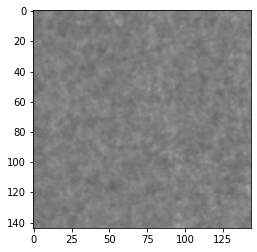

In [75]:
path = DATADIR # path to mit_Defekt or ohne_Defekt directory
for img in os.listdir(path):
  img_array = cv2.imread(os.path.join(path,img))
  img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

  plt.imshow(img_array)
  plt.show()
  break

In [76]:
img_array.shape

(144, 144, 3)

In [138]:
def load_data(path):
  training_data = []
  IMAGE_SIZE = 144
  for img in os.listdir(path):
    try:
      img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
      img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) # Since cv2.imread reads BGR
      img_array = cv2.resize(img_array, (IMAGE_SIZE, IMAGE_SIZE))
      #img_array = cv2.equalizeHist(img_array)
      training_data.append([img_array])   
    except Exception as e:
      pass
  return training_data

def process_data(X):
  X = np.asarray(X)
  X = X.astype('float32') # Normalising and regularizing
  X = X  /(X.max() - X.min()) 
  X = np.squeeze(X) # Remove axes of length one
  return X



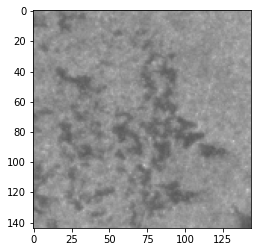

In [142]:
path2 = DATADEFEKT
defect_data = load_data(path2)
X_def = process_data(defect_data)
len(defect_data)

plt.imshow(X_def[1])

In [140]:
X = load_data(path)  
print("Total Data: ",len(X))
X = process_data(X)

X_train, X_test = train_test_split(X, test_size=0.15, random_state=42)

print("Training Data: ",len(X_train))
print("Test Data: ", len(X_test))
print(X.shape)
print(X_train.shape)
print(X_test.shape)

Total Data:  600
Training Data:  510
Test Data:  90
(600, 144, 144, 3)
(510, 144, 144, 3)
(90, 144, 144, 3)


In [122]:
# ax enables access to manipulate each of subplots
def plot_all():
  ax = []
  fig=plt.figure(figsize=(IMAGE_SIZE, IMAGE_SIZE))
  for i in range(len(training_data)):
    ax.append( fig.add_subplot(30,20, i+1) )
    #print(CATEGORIES[training_data[i][1]])
    #ax[-1].set_title(CATEGORIES[training_data[i][1]], fontdict={'fontsize': 8, 'fontweight': 'medium'})  # set title
    plt.imshow(training_data[i][0])
  plt.show()

def show_image(x):
    plt.imshow(x)
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


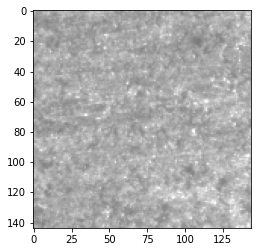

In [123]:
show_image(X_test[18])

In [99]:
input_shape = X.shape[1:]
print(input_shape)


(144, 144, 3)


In [174]:
input_img = keras.Input(shape=input_shape)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 144, 144, 3)]     0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 144, 144, 64)      1792      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 72, 72, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 72, 72, 32)        18464     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 36, 36, 16)        4624      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 18, 18, 16)        0  

In [175]:
# Network training
history = autoencoder.fit(X_train, X_train, epochs=200, batch_size=32, shuffle=True, validation_split=0.215)

Epoch 1/200
13/13 [==============================] - 3s 148ms/step - loss: 0.6553 - val_loss: 0.6269
Epoch 2/200
13/13 [==============================] - 1s 104ms/step - loss: 0.6229 - val_loss: 0.6219
Epoch 3/200
13/13 [==============================] - 1s 105ms/step - loss: 0.6197 - val_loss: 0.6214
Epoch 4/200
13/13 [==============================] - 1s 105ms/step - loss: 0.6199 - val_loss: 0.6214
Epoch 5/200
13/13 [==============================] - 1s 105ms/step - loss: 0.6201 - val_loss: 0.6211
Epoch 6/200
13/13 [==============================] - 1s 104ms/step - loss: 0.6196 - val_loss: 0.6211
Epoch 7/200
13/13 [==============================] - 1s 105ms/step - loss: 0.6188 - val_loss: 0.6212
Epoch 8/200
13/13 [==============================] - 1s 105ms/step - loss: 0.6204 - val_loss: 0.6213
Epoch 9/200
13/13 [==============================] - 1s 104ms/step - loss: 0.6190 - val_loss: 0.6207
Epoch 10/200
13/13 [==============================] - 1s 104ms/step - loss: 0.6194 - val_lo

In [159]:
autoencoder.save_weights('model_working_v2_64_Kernels.h5')

In [160]:
!ls

Dataset  Documents  model_working_v1.h5  model_working_v2_64_Kernels.h5


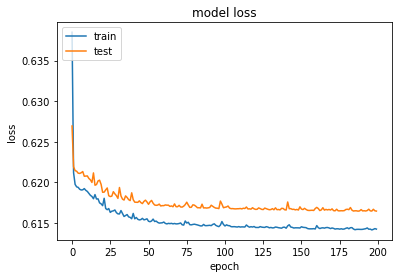

In [176]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

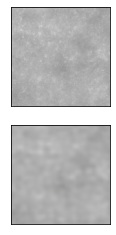

In [177]:
decoded_imgs = autoencoder.predict(X_test)
decoded_imgs = np.squeeze(decoded_imgs)

decoded_defekt = autoencoder.predict(X_def)


#show_image(X_test[18])
#show_image(decoded_imgs[18])

#print(X_test[18])
#print(decoded_imgs[18])
# #decoded_imgs.shape

n = 1
#plt.figure()
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


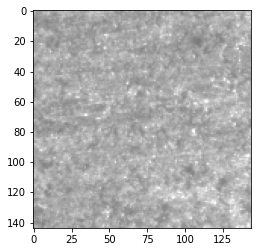

In [178]:
show_image(X_test[18])

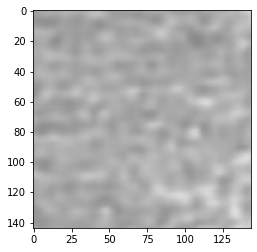

In [179]:
show_image(decoded_imgs[18])

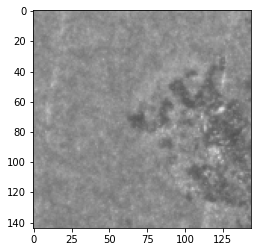

In [180]:
show_image(X_def[2])

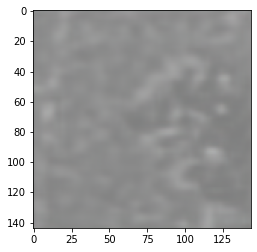

In [181]:
show_image(decoded_defekt[2])

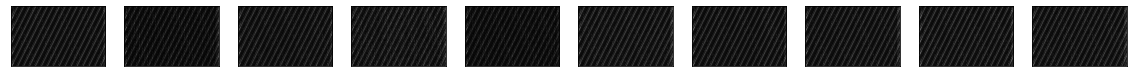

In [170]:
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((256, int(41472/256))).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [154]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder